<a href="https://colab.research.google.com/github/TitusChoi/Novelist_Classification/blob/yuls/Baseline_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이터 살펴보기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

In [ ]:
#경로 설정
import os
os.chdir('./')

In [ ]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/sample_submission.csv', encoding = 'utf-8')

In [ ]:
sample_submission

,Unnamed: 0,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0
4,4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
27314,27314,27314,0,0,0,0,0,0,0,0
27315,27315,27315,0,0,0,0,0,0,0,0
27316,27316,27316,0,0,0,0,0,0,0,0
27317,27317,27317,0,0,0,0,0,0,0,0


In [ ]:
#train 데이터 살펴보기
train
train.rename(columns={'Unnamed: 0':'index'}, inplace = True)
train

,index,text,author
0,0,It is hard to forget repulsive things. I remem...,6
1,1,It would be tedious if given in the beadle’s w...,7
2,2,“Very good. Shall we argue about it here in p...,2
3,3,“What! and I as high as a tree and as big as a...,6
4,4,"""Isn't it enough, Vanya?"" she cried, seeing hi...",3
...,...,...,...
83215,83215,"What with the birthday visitors, and what with...",7
83216,83216,It was an old rickety door and gave at once be...,2
83217,83217,"“Well then you can go to the devil,” said odin...",3
83218,83218,“Don’t know?”,7


In [ ]:
#test 데이터 살펴보기
test = test[['index', 'text']]
test

,index,text
0,0,"About thirty years ago Miss Maria Ward, of Hun..."
1,1,"Their homes were so distant, and the circles i..."
2,2,The letter was not unproductive. It re-establi...
3,3,"Such were its immediate effects, and within a ..."
4,4,Sir Thomas could not give so instantaneous and...
...,...,...
27313,27313,"At the end of another day or two, odin growing..."
27314,27314,"All afternoon we sat together, mostly in silen..."
27315,27315,"odin, having carried his thanks to odin, proc..."
27316,27316,"Soon after this, upon odin's leaving the room,..."


In [ ]:
#sample_submission
sample_submission

for i in range(19617, 27318):
    sample_submission = sample_submission.append(
        {
            'index': i,
            '0': 0,
            '1': 0,
            '2': 0,
            '3': 0,
            '4': 0,
            '5': 0,
            '6': 0,
            '7': 0
        },
        ignore_index=True)
    
sample_submission

In [ ]:
sample_submission.to_csv('sample_submission.csv')

# **전처리**

In [ ]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)

In [ ]:
#부호가 사라진 것을 확인할 수 있습니다.
train['text'][4]

'Isnt it enough Vanya she cried seeing his grimace Its all Ive got she added plaintively'

#### 불용어 지정해서 지우기

In [ ]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in base_stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
base_stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [ ]:
len(base_stopwords)

153

In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [ ]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

#### nltk 라이브러리를 사용한 불용어 제거

In [ ]:
# nltk 라이브러리를 사용한 불용어 제거
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

nltk_stopword = set(stopwords.words('english'))

# Stopword 만 제거한 결과
def remove_stopwords_nltk(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in nltk_stopword:
            final_text.append(i.strip())
    return " ".join(final_text)


# train['text'] = train['text'].str.lower()
# test['text'] = test['text'].str.lower()
# train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords_nltk)
# test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords_nltk)

# X_train = np.array([x for x in train['text']])
# X_test = np.array([x for x in test['text']])
# y_train = np.array([x for x in train['author']])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Vocab_size 확인

In [ ]:
tmp = train

for i in range(len(tmp['text'])):
    tmp['text'][i] = tmp['text'][i].strip().split()

vocab = nltk.FreqDist(np.hstack(tmp['text']))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 63727


# **모델링**

In [ ]:
# FastText 사용
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
pip install -U gensim

In [ ]:
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Novelist_Classification/Embedding/fasttext.vec')

In [ ]:
Word2Vec_model = gensim.models.KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/Novelist_Classification/Embedding/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
#파라미터 설정
vocab_size = 63727
embedding_dim = 16
max_length = 212
padding_type='post'
#oov_tok = "<OOV>"

In [ ]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size) #, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
# len(train_sequences)
idx = []
for i in range(len(train_sequences)):
    if len(train_sequences[i]) > 213 :
        idx.append(i)

# len(idx)
# type(X_train)
# X_train = np.delete(X_train,idx,0)
# y_train = np.delete(y_train, idx)

train = train.drop(idx)



In [ ]:
tmp = train

vocab = nltk.FreqDist(np.hstack(tmp['text']))
print('단어 집합의 크기 : {}'.format(len(vocab)))

단어 집합의 크기 : 63162


In [ ]:
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [ ]:
#파라미터 설정
vocab_size = 63162
embedding_dim = 16
max_length = 212
padding_type='post'
#oov_tok = "<OOV>"

In [ ]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size) #, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)

# train_sequences
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# train_padded
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

#### 1. Word2Vec

In [ ]:
# Word2Vec 임베딩 과정
W2V_embedding_matrix = np.zeros((vocab_size,300))

def get_vector(word):
    if word in Word2Vec_model:
        return Word2Vec_model[word]
    else:
        return None


In [ ]:
# print(vocab.items())
for idx, word in word_index.items():

    temp = get_vector(word)
    if temp is not None:
        W2V_embedding_matrix[idx] = temp
        
print(W2V_embedding_matrix.shape)

(63727, 300)


In [ ]:
vocab.items()

dict_items([('hard', 868), ('forget', 424), ('repulsive', 37), ('things', 1576), ('remember', 1127), ('yet', 2765), ('ran', 786), ('off', 3198), ('school', 317), ('boy', 1628), ('pretty', 1108), ('late', 731), ('night', 2700), ('concluded', 169), ('climb', 51), ('window', 977), ('fathers', 495), ('office', 403), ('sleep', 557), ('lounge', 9), ('delicacy', 142), ('going', 2665), ('home', 1998), ('getting', 602), ('thrashed', 29), ('lay', 1283), ('eyes', 3275), ('grew', 372), ('accustomed', 139), ('darkness', 286), ('fancied', 170), ('see', 6407), ('long', 4039), ('dusky', 25), ('shapeless', 17), ('thing', 2910), ('stretched', 189), ('upon', 8105), ('floor', 529), ('cold', 792), ('shiver', 40), ('went', 3608), ('turned', 1996), ('face', 3378), ('wall', 585), ('not', 28838), ('answer', 1220), ('afraid', 1010), ('creep', 34), ('seize', 53), ('dark', 1048), ('back', 3917), ('stared', 232), ('minutes', 910), ('minutesthey', 1), ('seemed', 2561), ('hours', 837), ('appeared', 901), ('lagging',

In [ ]:
word_index.items()

dict_items([('odin', 1), ('not', 2), ('said', 3), ('no', 4), ('one', 5), ('mr', 6), ('will', 7), ('now', 8), ('upon', 9), ('man', 10), ('know', 11), ('time', 12), ('little', 13), ('well', 14), ('see', 15), ('like', 16), ('come', 17), ('much', 18), ('must', 19), ('never', 20), ('good', 21), ('say', 22), ('can', 23), ('think', 24), ('two', 25), ('mrs', 26), ('us', 27), ('made', 28), ('old', 29), ('go', 30), ('great', 31), ('miss', 32), ('every', 33), ('nothing', 34), ('way', 35), ('might', 36), ('may', 37), ('dont', 38), ('came', 39), ('away', 40), ('first', 41), ('long', 42), ('sir', 43), ('back', 44), ('though', 45), ('thought', 46), ('last', 47), ('cried', 48), ('day', 49), ('without', 50), ('shall', 51), ('hand', 52), ('went', 53), ('make', 54), ('even', 55), ('looked', 56), ('young', 57), ('odins', 58), ('still', 59), ('face', 60), ('ever', 61), ('house', 62), ('eyes', 63), ('take', 64), ('just', 65), ('head', 66), ('off', 67), ('tell', 68), ('dear', 69), ('look', 70), ('got', 71), 

#### 2. Fasttext

In [ ]:
# Fasttext 임베딩 과정
FT_embedding_matrix = np.zeros((vocab_size,100))

def get_vector(word):
    if word in FastText:
        return FastText[word]
    else:
        return None

for word, idx in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix[idx] = temp
'''
for idx, word in word_index.items():
    if word in FastText:
      embedding_vector = FastText[word]
      FT_embedding_matrix[idx] = embedding_vector
'''

'\nfor idx, word in word_index.items():\n    if word in FastText:\n      embedding_vector = FastText[word]\n      FT_embedding_matrix[idx] = embedding_vector\n'

#### 3. glove

In [ ]:
# 사전 학습된 glove 불러오고 임베딩 층에 적용시키기 
embedding_dict= dict()
f = open('/content/drive/MyDrive/Novelist_Classification/Embedding/glove.txt', encoding='utf8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close

glove_embedding_matrix = np.zeros((vocab_size+1, 50))

for word, i in word_index.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        glove_embedding_matrix[i] = temp

# Modeling

In [ ]:
#가벼운 NLP모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 212, 16)           1019632   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 200       
Total params: 1,020,240
Trainable params: 1,020,240
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# fit model
num_epochs = 20
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

Epoch 1/20
2079/2079 - 26s - loss: 1.8914 - accuracy: 0.2671 - val_loss: 1.6212 - val_accuracy: 0.3722
Epoch 2/20
2079/2079 - 25s - loss: 1.4665 - accuracy: 0.4377 - val_loss: 1.4031 - val_accuracy: 0.4725
Epoch 3/20
2079/2079 - 25s - loss: 1.2703 - accuracy: 0.5178 - val_loss: 1.2690 - val_accuracy: 0.5194
Epoch 4/20
2079/2079 - 25s - loss: 1.1292 - accuracy: 0.5757 - val_loss: 1.1788 - val_accuracy: 0.5454
Epoch 5/20
2079/2079 - 25s - loss: 1.0103 - accuracy: 0.6251 - val_loss: 1.0980 - val_accuracy: 0.5854
Epoch 6/20
2079/2079 - 25s - loss: 0.9142 - accuracy: 0.6597 - val_loss: 1.0595 - val_accuracy: 0.5913
Epoch 7/20
2079/2079 - 25s - loss: 0.8382 - accuracy: 0.6864 - val_loss: 1.0164 - val_accuracy: 0.6180
Epoch 8/20
2079/2079 - 25s - loss: 0.7755 - accuracy: 0.7086 - val_loss: 1.0032 - val_accuracy: 0.6115
Epoch 9/20
2079/2079 - 25s - loss: 0.7229 - accuracy: 0.7265 - val_loss: 0.9615 - val_accuracy: 0.6347
Epoch 10/20
2079/2079 - 25s - loss: 0.6800 - accuracy: 0.7412 - val_loss:

#Result of Train  
## Base stopwords + Keras Embedding  
1372/1372 - 7s - loss: 0.4276 - accuracy: 0.8455 - val_loss: 0.7625 - val_accuracy: 0.7305
## Base stopwords + FastText  
1372/1372 - 78s - loss: 0.4719 - accuracy: 0.8304 - val_loss: 0.7002 - val_accuracy: 0.7514
## Base stopwords + Word2Vec
1372/1372 - 256s - loss: 0.4028 - accuracy: 0.8531 - val_loss: 0.7596 - val_accuracy: 0.7366





# LSTM 모델

### 1.  Fastex 사용


#### unit 30

In [ ]:
model_FT_lstm_30 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=30),
    
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_FT_lstm_30.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_30.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 20
history = model_FT_lstm_30.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 212, 100)          6316200   
_________________________________________________________________
lstm_13 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 248       
Total params: 6,332,168
Trainable params: 6,332,168
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
260/260 - 22s - loss: 2.0415 - accuracy: 0.1784 - val_loss: 2.0355 - val_accuracy: 0.1857
Epoch 2/20
260/260 - 21s - loss: 2.0388 - accuracy: 0.1810 - val_loss: 2.0349 - val_accuracy: 0.1866
Epoch 3/20
260/260 - 21s - loss: 2.0373 - accuracy: 0.1815 - val_loss: 2.0339 - val_accuracy: 0.1873
Epoch 4/20
260/260 - 20s - loss: 2.0353 - accuracy: 0.1829 - val_l


#### unit 50

In [ ]:
model_FT_lstm_50 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=50),
    
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_FT_lstm_50.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_50.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 20
history = model_FT_lstm_50.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 212, 100)          6316200   
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 408       
Total params: 6,346,808
Trainable params: 6,346,808
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
260/260 - 23s - loss: 2.0416 - accuracy: 0.1803 - val_loss: 2.0373 - val_accuracy: 0.1860
Epoch 2/20
260/260 - 20s - loss: 2.0386 - accuracy: 0.1812 - val_loss: 2.0370 - val_accuracy: 0.1854
Epoch 3/20
260/260 - 20s - loss: 2.0379 - accuracy: 0.1813 - val_loss: 2.0340 - val_accuracy: 0.1867
Epoch 4/20
260/260 - 20s - loss: 2.0353 - accuracy: 0.1820 - val_

#### unit 128

In [ ]:
model_FT_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_FT_lstm_128.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_128.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 1000
history = model_FT_lstm_128.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 212, 100)          6316200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
Total params: 6,434,480
Trainable params: 6,434,480
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
260/260 - 58s - loss: 2.0455 - accuracy: 0.1789 - val_loss: 2.0371 - val_accuracy: 0.1852
Epoch 2/1000
260/260 - 28s - loss: 2.0400 - accuracy: 0.1805 - val_loss: 2.0382 - val_accuracy: 0.1854
Epoch 3/1000
260/260 - 28s - loss: 2.0381 - accuracy: 0.1807 - val_loss: 2.0337 - val_accuracy: 0.1864
Epoch 4/1000
260/260 - 25s - loss: 1.9994 - accuracy: 0.1911 -

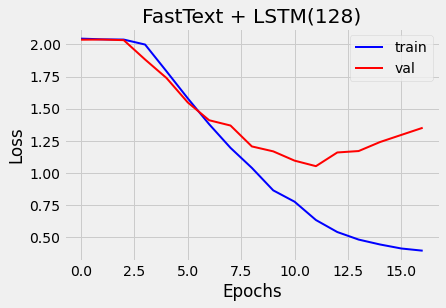

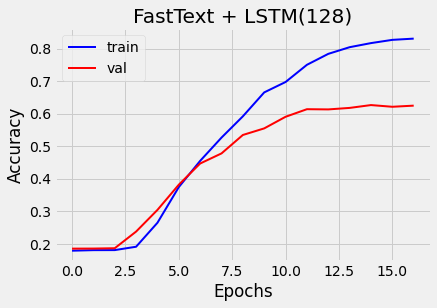

In [ ]:
import matplotlib.pyplot as plt


def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.figure(2)
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'FastText + LSTM(128)')

        1. 첫번째 실험
        unit 수를 늘리면 성능이 올라갈까?
        unit128일 경우에 가장 성능이 좋았으나 val_loss, val_acc의 성능이 train과 차이가 많이 남

        번외)
        batch수를 1024, 512, 256, 64 등으로 맞춰서 진행해본 결과 batch수가 너무 클 경우 학습이 금방끝났지만 성능이 좋지 못했고,
        batch가 작을 경우 시간이 오래걸렸으나 batch수가 큰 경우보다 약간의 성능이 높았다.
        이번 실험에서는 256을 사용하여 실험을 해보았다.

        adam / batch 256 / val_split 0.2 / unit 30,50,128

#### lstm-cnn 사용하기

In [ ]:
model_FT_lstm_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,weights = [FT_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding="same"),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])


# compile model
model_FT_lstm_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_cnn.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7 ,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 100
history = model_FT_lstm_cnn.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 64,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 212, 100)          6316200   
_________________________________________________________________
conv1d (Conv1D)              (None, 212, 128)          38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 106, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 6,487,344
Trainable params: 6,487,344
Non-trainable params: 0
____________________________________________

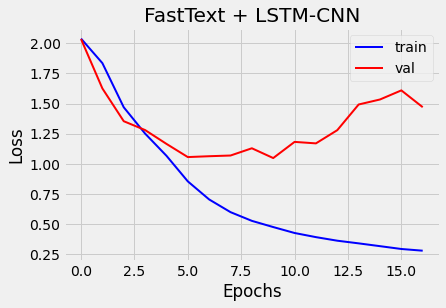

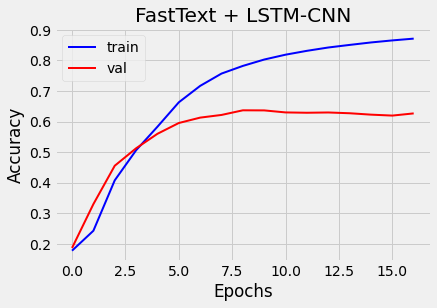

In [ ]:
import matplotlib.pyplot as plt


def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.figure(2)
    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'FastText + LSTM-CNN')

        LSTM-CNN모델

        Embedding > conv > maxpooling> LSTM > Dropout > Dense

        adam / FastText / batch = 64 / dropout = 0.5 / filter = 128
    

        단일층의 unit 128모델과 비교했을때, acc는 약 3% 오르고 loss는 10 % 줄어든 성능을 보였다.
        하지만 val_loss의 경우 unit128보다 높으며 train과 성능 차이가 좀 더 났음을 확인했다.

        이 그렇다면 CNN의 츨을 높인다면 어떨까? 실험해보았지만 성능이 좋지않아 결과에서 제외시켰습니다. (논문과 별개로 개인적인 실험)

### 2. Glove 사용

#### unit 30

In [ ]:
model_G_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),

    tf.keras.layers.LSTM(units=30),

    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_G_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_G_lstm.summary())


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 30
history = model_G_lstm.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 212, 50)           3158150   
_________________________________________________________________
lstm_29 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 248       
Total params: 3,168,118
Trainable params: 3,168,118
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
260/260 - 13s - loss: 2.0428 - accuracy: 0.1797 - val_loss: 2.0382 - val_accuracy: 0.1850
Epoch 2/30
260/260 - 11s - loss: 2.0403 - accuracy: 0.1802 - val_loss: 2.0375 - val_accuracy: 0.1852
Epoch 3/30
260/260 - 11s - loss: 2.0394 - accuracy: 0.1801 - val_loss: 2.0336 - val_accuracy: 0.1867
Epoch 4/30
260/260 - 11s - loss: 2.0364 - accuracy: 0.1816 - val_

unit 50

In [ ]:
model_G_lstm_50 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),

    tf.keras.layers.LSTM(units=50),

    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_G_lstm_50.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_G_lstm_50.summary())


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

# fit model
num_epochs = 20
history = model_G_lstm_50.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2,batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 212, 50)           3158150   
_________________________________________________________________
lstm_31 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 408       
Total params: 3,178,758
Trainable params: 3,178,758
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
260/260 - 13s - loss: 2.0420 - accuracy: 0.1794 - val_loss: 2.0376 - val_accuracy: 0.1851
Epoch 2/20
260/260 - 10s - loss: 2.0407 - accuracy: 0.1800 - val_loss: 2.0372 - val_accuracy: 0.1852
Epoch 3/20
260/260 - 10s - loss: 2.0390 - accuracy: 0.1806 - val_loss: 2.0332 - val_accuracy: 0.1861
Epoch 4/20
260/260 - 10s - loss: 1.9654 - accuracy: 0.2037 - val_

unit 128

In [ ]:
model_G_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dense(8, activation='softmax')
])

# compile model
model_G_lstm_128.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_G_lstm_128.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, 
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 1000
history = model_G_lstm_128.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 256,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 212, 50)           3158150   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 3,250,830
Trainable params: 3,250,830
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
260/260 - 18s - loss: 2.0487 - accuracy: 0.1776 - val_loss: 2.0373 - val_accuracy: 0.1852
Epoch 2/1000
260/260 - 18s - loss: 2.0475 - accuracy: 0.1802 - val_loss: 2.0378 - val_accuracy: 0.1850
Epoch 3/1000
260/260 - 19s - loss: 2.0404 - accuracy: 0.1796 - val_loss: 2.0378 - val_accuracy: 0.1851
Epoch 4/1000
260/260 - 19s - loss: 2.0401 - accuracy: 0.1803

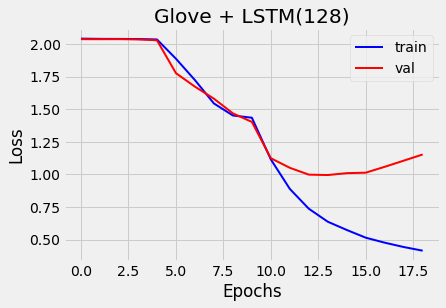

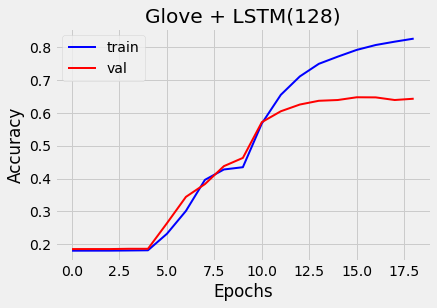

In [ ]:
#에포크에 따른 loss와 accuracy 변화 그래프
def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)

    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.figure(2)

    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'Glove + LSTM(128)')

    1. 첫번째 실험
    unit 수를 늘리면 성능이 올라갈까?
    FastText와 마찬가지로 Glove 임베딩을 사용한 단일층 unit128일 경우에 82.6%로 가장 성능이 좋았다
    하지만 여깃도 val_loss, val_acc의 성능이 train과 차이가 많이 났음을 알 수 있다.
 
 
    adam / batch 256 / val_split 0.2 / unit 30,50,128

#### lstm-cnn 사용하기

In [ ]:
model_FT_lstm_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 50,weights = [glove_embedding_matrix] ,input_length=max_length),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding="same"),
    tf.keras.layers.LSTM(units=128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])


# compile model
model_FT_lstm_2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model_FT_lstm_2.summary())

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7 ,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
# fit model
num_epochs = 100
history = model_FT_lstm_2.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, batch_size = 64,
                    validation_split=0.2, callbacks = [early_stopping])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 212, 50)           3158150   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 212, 128)          19328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 106, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 3,310,094
Trainable params: 3,310,094
Non-trainable params: 0
____________________________________________

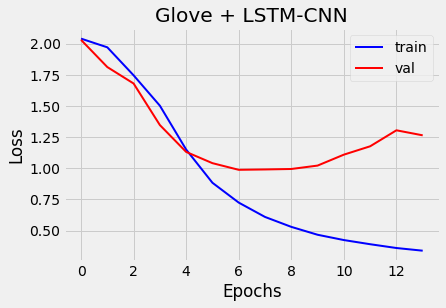

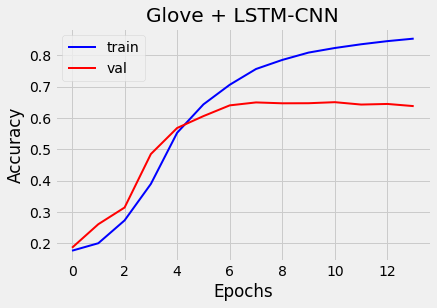

In [ ]:
def plot_model_perfomance(history,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)

    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.figure(2)

    plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

plot_model_perfomance(history,'Glove + LSTM-CNN')

        LSTM-CNN모델

        Embedding > conv > maxpooling> LSTM > Dropout > Dense

        adam / FastText / batch = 64 / dropout = 0.5 / filter = 128
    

        단일층의 unit 128모델과 비교했을때, acc는 약 3% 오르고 loss는 8 % 줄어든 성능을 보였다.
        하지만 val_loss의 경우 unit128보다 높았으며, train과 성능 차이가 좀 더 났음을 확인했다.



        결국 LSTM-CNN 모델의 성능이 좋았는데
        이번 결과에서는 FastText를 사용하는게 acc와 loss 측면에서 더 좋은 결과를 얻었다.
        (acc=87%, loss=28%)

        하지만 validation과의 차이가 좀 있기 때문에 줄일수 있는 방법을 강구해야할 것 같다.
        하이퍼 파라미터의 조정, 층을 늘리기, 다른 모델과의 결합등을 고려해서 실험해볼 수 있을 것 같다.


#### 테스트 진행

In [ ]:
sample_submission

,Unnamed: 0,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,2,2,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0
4,4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
27313,27313,27313,0,0,0,0,0,0,0,0
27314,27314,27314,0,0,0,0,0,0,0,0
27315,27315,27315,0,0,0,0,0,0,0,0
27316,27316,27316,0,0,0,0,0,0,0,0


In [ ]:
pred_FT_128 = model_FT_lstm_128.predict(test_padded)
pred_FT_128

array([[7.1802796e-03, 5.9519794e-02, 1.0558590e-02, ..., 6.8579817e-01,
        1.8825267e-01, 1.3612258e-02],
       [3.4382206e-04, 4.2951632e-02, 5.0385419e-04, ..., 9.5343834e-01,
        8.1937597e-04, 1.5186310e-03],
       [2.1104661e-03, 2.4650526e-01, 1.3975509e-03, ..., 7.4528551e-01,
        3.6738114e-04, 2.3646562e-03],
       ...,
       [7.9944311e-03, 9.8469824e-01, 4.4701676e-04, ..., 3.6994424e-03,
        2.8827869e-06, 6.4790656e-05],
       [7.9357978e-03, 9.8449928e-01, 4.6248146e-04, ..., 3.7465072e-03,
        3.0600108e-06, 6.5168613e-05],
       [1.0862062e-02, 5.0930289e-06, 2.6215479e-05, ..., 7.7429868e-06,
        1.8635967e-04, 9.8884881e-01]], dtype=float32)

In [ ]:
len(pred_FT_128)

27318

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_FT_128
sample_submission.to_csv('submission_FT_128.csv', index = False)

In [ ]:
pred_FT_cnn = model_FT_lstm_cnn.predict(test_padded)
pred_FT_cnn

array([[3.3333901e-02, 1.0812887e-01, 4.4248659e-02, ..., 2.8458515e-01,
        2.4149300e-01, 1.1512893e-01],
       [5.2333800e-03, 1.2624253e-01, 9.4579160e-02, ..., 2.7886689e-01,
        2.8084314e-01, 4.3254856e-02],
       [7.2327536e-04, 2.4251144e-01, 1.0800808e-03, ..., 7.5186402e-01,
        8.7356434e-04, 1.9605558e-03],
       ...,
       [5.1681004e-03, 9.9203217e-01, 6.9521158e-04, ..., 1.2658454e-03,
        1.6840557e-05, 4.1827156e-05],
       [1.0851536e-02, 9.8607630e-01, 1.0942775e-03, ..., 7.2759268e-04,
        1.9158884e-05, 5.7271769e-05],
       [4.1877840e-02, 1.5277258e-03, 1.5737818e-03, ..., 3.0353931e-03,
        1.4939275e-02, 9.3383074e-01]], dtype=float32)

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_sample_submission.csv', encoding = 'utf-8')

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_FT_cnn
sample_submission.to_csv('submission_FT_cnn.csv', index = False)

In [ ]:
pred_G_128 = model_G_lstm_128.predict(test_padded)
pred_G_128

array([[0.01750951, 0.09280887, 0.0298206 , ..., 0.3438935 , 0.42461947,
        0.02314765],
       [0.1554916 , 0.0861906 , 0.1352335 , ..., 0.08800144, 0.10384267,
        0.15995173],
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ],
       ...,
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ],
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ],
       [0.15549092, 0.0861913 , 0.1352333 , ..., 0.08800189, 0.10384335,
        0.1599511 ]], dtype=float32)

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_G_128
sample_submission.to_csv('submission_G_128.csv', index = False)

In [ ]:
pred_G_cnn = model_FT_lstm_2.predict(test_padded)
pred_G_cnn

array([[4.1665707e-02, 2.4673013e-01, 8.4210090e-02, ..., 3.9300770e-01,
        8.9864232e-02, 3.2006562e-02],
       [9.2443719e-04, 3.3385196e-01, 5.5370590e-04, ..., 6.6116250e-01,
        1.2769245e-03, 1.6869067e-03],
       [1.7114145e-03, 4.9232084e-01, 1.4868027e-03, ..., 4.9536091e-01,
        4.9755634e-03, 3.0130665e-03],
       ...,
       [3.1380146e-03, 9.9454749e-01, 6.3926727e-04, ..., 9.7871339e-04,
        4.9235401e-05, 7.8142129e-06],
       [2.5092922e-03, 9.9515641e-01, 7.0697861e-04, ..., 9.8816084e-04,
        6.1592327e-05, 6.7113015e-06],
       [4.5687139e-01, 8.6204219e-04, 7.6862925e-04, ..., 2.9795588e-04,
        4.6375368e-04, 5.3314763e-01]], dtype=float32)

In [ ]:
sample_submission[['0','1','2','3','4','5','6','7']] = pred_G_cnn
sample_submission.to_csv('submission_G_cnn.csv', index = False)